# Introduction to Synthetic Aperture Radar Using Python and MATLAB 

## by Andy Harrison - © 2022 Artech House

---

## Example 3.4.3 Range Doppler Algorithm - Point Targets

---

**Import Modules**

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from scipy.constants import speed_of_light, pi

from scipy.io import loadmat

from matplotlib import pyplot as plt

import sys


**Load the signal data**

In [2]:
data = loadmat('signal.mat')

signal = np.squeeze(data['signal'])

frequency = np.squeeze(data['frequency'])

range_center = np.squeeze(data['range_center'])

synthetic_aperture = np.squeeze(data['synthetic_aperture'])

aperture_length = np.squeeze(data['aperture_length'])

**Find the number of signal samples**

In [3]:
nAz, nRange = signal.shape

**Set the FFT sizes**

In [4]:
# Next power of 2 = np.ceil(np.log2(N))

nfft_Range = 16 * 2**np.ceil(np.log2(nRange))

nfft_Az = 2**np.ceil(np.log2(nAz))

**Calculate the slant range window (m)**

In [5]:
range_window_length = speed_of_light / (2 * (frequency[1] - frequency[0]))

slant_range = np.linspace(-range_window_length/2, range_window_length/2, int(nfft_Range))

**Get the center frequency (Hz)**

In [6]:
center_frequency = frequency[int(len(frequency)/2)]

**Calculate the wavelength (m)**

In [7]:
wavelength = speed_of_light / center_frequency

**Set the window type for range compression**

In [8]:
window = 'none'

**Get the window coefficients**

In [9]:
if window == 'Hanning':
    
    coefficients = np.hanning(nRange)

elif window == 'Hamming':

    coefficients = np.hamming(nRange)
    
else:
    
    coefficients = np.ones(nRange)

**Perform range compression**

In [10]:
Hf = np.exp(1j * 4.0 * pi * frequency / speed_of_light * range_center[int(len(range_center)/2)]) * coefficients

Sf = signal
            
rd_data_corrected = np.zeros((nAz, int(nfft_Range)), dtype=complex)

**Loop over each range line**

In [11]:
for i in range(nAz):
    
    rd_data_corrected[i, :] = np.fft.fftshift(np.fft.ifft(Sf[i, :] * Hf, int(nfft_Range)))

**Set the PRF (Hz)**

In [12]:
prf = 850

frequency = np.linspace(-0.5 * prf, 0.5 * prf, nAz)

**Plot the range compressed data**

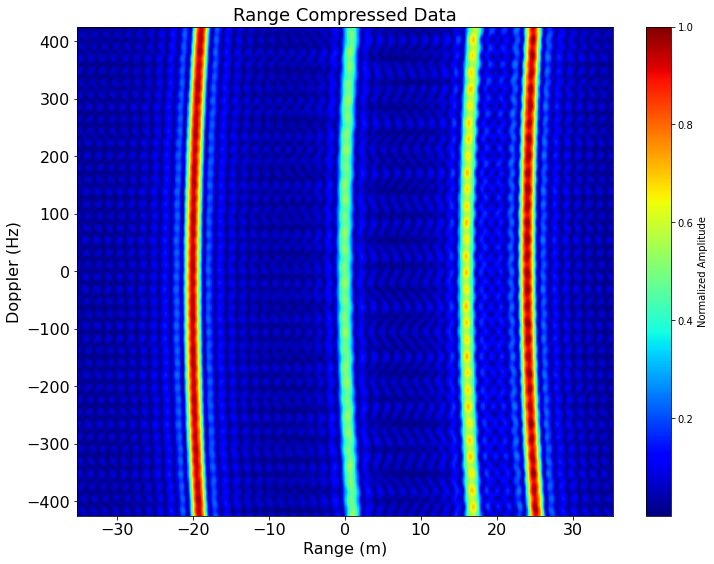

In [13]:
# Set the figure size

plt.rcParams["figure.figsize"] = (12, 9)



# Plot the range compressed data

plt.figure

plt.pcolor(slant_range, frequency, np.abs(rd_data_corrected)/np.max(np.abs(rd_data_corrected)), cmap='jet')




# Set the title and labels

plt.title('Range Compressed Data', size=18)

plt.xlabel('Range (m)', size=16)

plt.ylabel('Doppler (Hz)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

# plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Turn on the colorbar and set the label

cbar = plt.colorbar()

cbar.set_label('Normalized Amplitude')



# Show the figure

plt.show()

**Convert the range compressed data to range Doppler domain for range cell migration correction**

In [14]:
rd_data = np.fft.fftshift(np.fft.fft(rd_data_corrected, axis=0), 0)

**Calculate the slant range spacing (m)**

In [15]:
rc = range_center[int(len(range_center)/2)]

slant_range_spacing = slant_range[1] - slant_range[0]

**The effective velocity (m/s)**

In [16]:
v_eff = 100

**Data size**

In [17]:
[nA, nR] = rd_data.shape

**Frequency shift (Hz)**

In [18]:
frequency = np.linspace(-0.5 * prf, 0.5 * prf, nA)

**Calculate the RCMC offset**

In [19]:
offsets = (1 / np.sqrt(1 - (wavelength * frequency / (2 * v_eff) )**2) - 1) * rc

offsets = np.round(offsets / slant_range_spacing) 

frequency = frequency * 5

**Index the RCMC data from the offset range doppler data**

In [20]:
rcmc_data = np.zeros_like(rd_data)

i = 0

for offset in offsets:
    
    rcmc_data[i, :] = np.roll(rd_data[i, :], -int(offset))
    
    i += 1

**Plot the range cell migration corrected data**

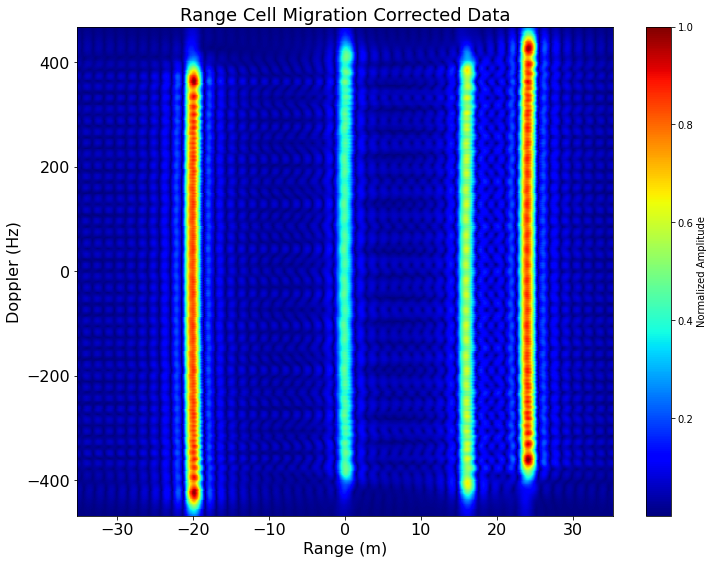

In [21]:
plt.figure

plt.pcolor(slant_range, frequency, np.abs(rcmc_data)/np.max(np.abs(rcmc_data)), cmap='jet')

plt.ylim([-0.5 * prf - 0.05 * prf, 0.5 * prf + 0.05 * prf])



# Set the title and labels

plt.title('Range Cell Migration Corrected Data', size=18)

plt.xlabel('Range (m)', size=16)

plt.ylabel('Doppler (Hz)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

# plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Turn on the colorbar and set the label

cbar = plt.colorbar()

cbar.set_label('Normalized Amplitude')



# Show the figure

plt.show()

**After RCMC convert back to range azimuth domain**

In [22]:
rd_data_corrected = np.fft.ifft(np.fft.ifftshift(rcmc_data, 0), axis=0)

**Set the window type for azimuth compression**

In [23]:
window = 'none'

**Get the window coefficients**

In [24]:
if window == 'Hanning':
    
    coefficients = np.hanning(nAz)

elif window == 'Hamming':

    coefficients = np.hamming(nAz)
    
else:
    
    coefficients = np.ones(nAz)

**Set up the image array**

In [25]:
range_doppler_image = np.zeros((int(nfft_Az), int(nfft_Range)), dtype=complex)

**Loop over the range lines and perform azimuth compression**

In [26]:
center_index = int(np.floor(len(range_center) / 2))

i = 0

for sr in slant_range:
    
    a = coefficients * np.exp(1j * 4 * pi * center_frequency / speed_of_light * synthetic_aperture**2 / (range_center[center_index] + sr)) 

    af = np.fft.fft(a, int(nfft_Az))
    
    range_doppler_image[:,i] = np.fft.ifftshift(np.fft.ifft(np.fft.fft(rd_data_corrected[:,i], int(nfft_Az)) * af))
    
    i += 1

**Set up the cross range array**

In [27]:
cross_range = np.linspace(-0.5 * aperture_length * nAz / nfft_Az, 0.5 * aperture_length * nAz / nfft_Az, int(nfft_Az))

**Plot the final range Doppler image**

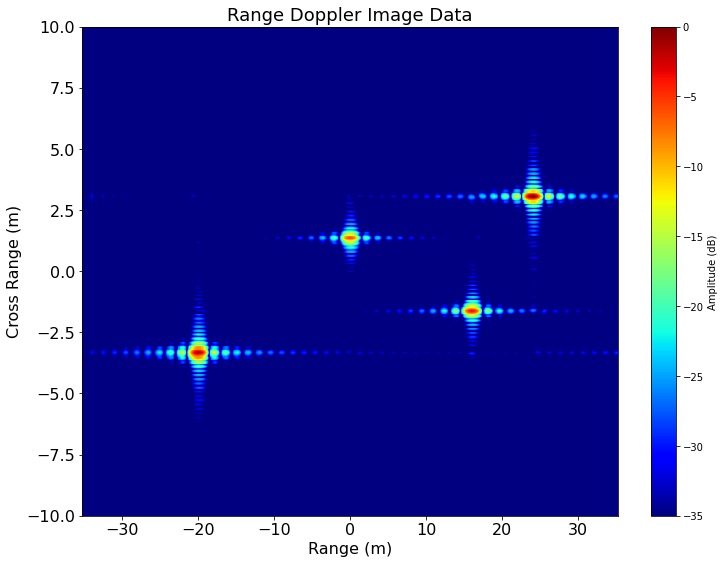

In [28]:
# Set the dynamic range for the image (dB)

dynamic_range = 35



# Display the figure

plt.figure

plt.pcolor(slant_range, cross_range + 45, 20 * np.log10(np.abs(range_doppler_image)/np.max(np.abs(range_doppler_image)) + sys.float_info.min), cmap='jet', vmin=-abs(dynamic_range), vmax=0)

plt.ylim([-10, 10])


# Set the title and labels

plt.title('Range Doppler Image Data', size=18)

plt.xlabel('Range (m)', size=16)

plt.ylabel('Cross Range (m)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Make the axes equal

# plt.axis('equal')

# plt.gca().set_aspect('equal', adjustable='box')



# Turn on the colorbar and set the label

cbar = plt.colorbar()

cbar.set_label('Amplitude (dB)')



# Show the figure

plt.show()